# Protea Gather

## Aim

Using cadCAD to model risk and reward thresholds for users of the system, and the system's resilience to instability, while protecting users against black swan type events.

## Method

Actors perform actions under different scenarios. 
These actions and scenarios occur within the constraints of the system policies.

## Notes

The cadCAD framework has been retroffited to support OOP style types and wrappers.

## Observations

### Number 1

Simply adding the y-axis shift doesn't greatly decrease or increase the users' end returns, but does decrease the whales end ROI enough that the average day-to-day user doesn't see the effect of them dumping.

### Number 2

The introduction of the y-axis shift creates a slow linear growth at a rate of around 3-8% (seen with randomness added), in comparison to 2.5x or more.

---

# System Summary

## Actors
### Creators
Actions
* Create community
* Create/start/end event

### Members
Actions
* Join/leave community
* Attend event

### Supporters
Actions
* Invest in community

---

## Scenarios
* Successful/unsuccessful communities
* Community liquidation
* Bad actors
* Bad community policies

---

## Policies
* Bonding curve parameters
* Community taxation
* Protocol taxation

---

## Module imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import math
from scipy.optimize import fsolve

from decimal import Decimal
import numpy as np

import ipywidgets as widgets
from IPython.display import display

from abc import ABC, abstractmethod
from enum import Enum, auto
from functools import partial
import random
import uuid
import json

import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='BenjaminScholtz', api_key='8HheLHWEyoXDuLOiQ4ZO')

import sys
sys.path.append("../lib/python3.7/site-packages")

## Business Logic/Contract Code

In [2]:
b_widget = widgets.FloatSlider(
    value=0,
    min=0,
    max=10,
    step=.01,
    description='y-axis shift',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    #readout_format='.1f',
)

display(b_widget)

FloatSlider(value=0.0, description='y-axis shift', max=10.0, step=0.01)

In [3]:
b = 0.5
gradient = 1/17_500

# Bonding curve parameters

# b = b_widget.value
# gradient = 1/2000

# Community parameters

community_tax_rate = 0.5
general_user_base_buy_in = 10

# Linear user base

time_steps = 40 # essentially user base with linear growth

# Sigmoidal user base

max_user_base = 50
sigmoid_inflection = 20
sigmoid_slope = 1/4

In [4]:
def linear_curve(x, gradient):
    #return gradient*x
    return gradient*x + b

def inverse_integral(xD, gradient=gradient):
    #return math.sqrt(2.0*xT/gradient)
    return (-b + math.sqrt(math.pow(b, 2.0) + 2.0*gradient*xD))/(gradient)

def curve_integral(xT, gradient=gradient):
    #return (math.pow(xD, 2.0)*gradient)/2.0
    return (math.pow(xT, 2.0)*gradient)/2.0 + b*xT

def price_to_mint(x_T, total_supply, pool_balance, gradient):
    d = curve_integral(total_supply + x_T, gradient) - pool_balance
    return d + d/100

def reward_for_burn(x_T, total_supply, pool_balance, gradient):
    return pool_balance - curve_integral(total_supply - x_T, gradient)

def collateral_to_token_buying(x_D, total_supply, gradient):
    x_D = x_D - x_D*0.01
    return inverse_integral(curve_integral(total_supply, gradient) + x_D, gradient) - total_supply

def collateral_to_token_selling(x_D, total_supply, gradient):
    try:
        return total_supply - inverse_integral(curve_integral(total_supply, gradient) - x_D, gradient)
    except ValueError:
        return 0

In [5]:

b = 0.5
gradient = 1/17_500
token_purchase = 100

dai = curve_integral(token_purchase)
print(dai)

supply = inverse_integral(dai)
print(supply)

reward_for_burn(1, supply, balance, 1/2000)*supply
collateral_to_token_selling(1, supply, 1/2000)

50.285714285714285
99.99999999999926


NameError: name 'balance' is not defined

In [6]:
curve_integral(1000000)

29071428.57142857

## Utility Functions

In [7]:
def id():
    return uuid.uuid4().int & (1<<64)-1

def bollinger_bands(value, window_size, num_of_std):

    rolling_mean = value.rolling(window=window_size).mean()
    rolling_std  = value.rolling(window=window_size).std()
    upper_band = rolling_mean + (rolling_std*num_of_std)
    lower_band = rolling_mean - (rolling_std*num_of_std)

    return rolling_mean, upper_band, lower_band

## Custom cadCAD type classes

In [8]:
class StateType(Enum):
    @classmethod
    def initial_state(cls):
        _members = {}
        for item in cls.__members__:
            _members[cls[item]] = 0
        return _members
    
    def initial_conditions(cls):
        print("initial_conditions not implemented")

class ActionsType(Enum):
    def __init__(self, *args, **kwargs):
        pass
    
    def method(self, *args):
        method = getattr(self.__class__, '_%s' % self.name)
        return method(*args)

class PoliciesType:
    def list(self):
        policies = [func for func in dir(self) 
                    if (callable(getattr(self, func)) 
                        and func != 'list' 
                        and func.find('_'))]
        returnVal = {}
        for func in policies: returnVal[func] = getattr(self, func)
        return returnVal

## Domain types

In [9]:
class Member:
    def __init__(self, period=0, buy_in=0):
        self.id = id()
        
        self.selected = False
        
        self.period = period
        self.buy_in = buy_in
        
        self.user_supply = 0
        self.user_balance = 0
        
class TxType(Enum):
    BUY = auto()
    SELL = auto()
    HOLD = auto()
    
class Transaction:
    def __init__(self, tx_type=TxType.BUY, value=10, periods=[], user_index=0):
        self.tx_type = tx_type
        self.value = value
        self.user_index = user_index
        self.periods = periods
        
    def get_buy_in(self, s):
        period = s['timestep']
        community_state = s[State.community_state]
        members = community_state.members
        
        if self.tx_type == TxType.BUY:
            return self.value
        elif self.tx_type == TxType.SELL:
            return -self.value
        elif self.tx_type == TxType.HOLD:
            if period == self.periods[0]:
                return self.value
            else:
                return -reward_for_burn(
                    members[self.user_index].user_supply, community_state.total_supply, community_state.pool_balance, s[State.gradient])
        else:
            return self.value

## Parameters

In [10]:
eta = .33 # for tx_volume_generator
tampw = 100000 # transactions limit
alpha = .5 # for data acquisition cost generator
beta = .2 # for data acquisition cost generator
costDecrease = .015 # decrease in cost

transaction_config = [
#     Transaction(TxType.BUY, 100, range(0, 36, 2), 0),
#     Transaction(TxType.BUY, 100, [1, 20], 0),
#     Transaction(TxType.BUY, 10, range(1, 36, 3), 1),
#     Transaction(TxType.BUY, 10, range(1, 36, 6), 2),
#     Transaction(TxType.HOLD, whale_dump, [1, dump_point], 0),
]

## States

In [11]:
class CommunityState:    
    def __init__(self, members=[], total_supply=0, pool_balance=0, protea_balance=0, community_supply=0, community_balance=0):
        self.members = members
        
        self.total_supply = total_supply
        self.pool_balance = pool_balance
        
        self.protea_balance = protea_balance
        
        self.community_supply = community_supply
        self.community_balance = community_balance
        
    def validate(self):
        assert self.pool_balance == reward_for_burn(self.total_supply) 
        
class State(StateType):
    gradient = auto()
    y_intercept = auto()
    community_tax_rate = auto()    
    
    community_state = auto()
    
    @classmethod
    def initial_conditions(cls):
        return {
            **cls.initial_state(), # If the initial condition is not defined, it defaults to 0
            cls.gradient: 1/2000,
            cls.community_tax_rate: community_tax_rate,
            cls.community_state: CommunityState(
                members=[
                    Member() for _ in transaction_config
                ]
            ),
        }
    
class StateExogenous(StateType):
    user_base = auto()
    tx_volume = auto()
    product_cost = auto()
    
    @classmethod
    def initial_conditions(cls):
        return {
            **cls.initial_state(),
            cls.tx_volume: 10,
        }
    
class StateAgregated(StateType):
    pool_balance = auto()
    
    @classmethod
    def initial_conditions(cls):
        return {
            **cls.initial_state()
        }

## Actions

In [12]:
class ActionsBonding(ActionsType):
    burn = auto()
    mint = auto()
    
    @classmethod
    def _burn(cls, params, step, sL, s, _input):
        community_state = s[State.community_state]
        members = community_state.members
        
        for member in members:
            if member.selected and (member.buy_in < 0):
                tokens = collateral_to_token_selling(abs(member.buy_in), community_state.total_supply, s[State.gradient])
                if tokens > member.user_supply:
                    tokens = member.user_supply
                reward_for_tokens = reward_for_burn(tokens, community_state.total_supply, community_state.pool_balance, s[State.gradient])
                
                community_state.total_supply -= tokens
                community_state.pool_balance = curve_integral(
                    community_state.total_supply, s[State.gradient])
                
                member.user_supply -= tokens
            
        return(State.community_state, community_state)

    @classmethod
    def _mint(cls, params, step, sL, s, _input):
        community_state = s[State.community_state]
        members = community_state.members
        
        for member in members:
            if member.selected and (member.buy_in >= 0):
                tokens = collateral_to_token_buying(member.buy_in, community_state.total_supply, s[State.gradient])
                tokens_price = price_to_mint(
                    tokens, community_state.total_supply, community_state.pool_balance, s[State.gradient])
                
                community_state.protea_balance += tokens_price*0.01

                community = tokens*s[State.community_tax_rate]
                community_state.community_supply += community
                community_state.community_balance = reward_for_burn(
                    community_state.community_supply, community_state.total_supply, community_state.pool_balance, s[State.gradient])

                community_state.total_supply += tokens
                community_state.pool_balance = curve_integral(
                        community_state.total_supply, s[State.gradient])
                
                member.user_supply += tokens - community
            
        return(State.community_state, community_state)
    
class ActionsExogenous(ActionsType):
    user_base_generator = auto()
    tx_volume_generator = auto()
    product_cost_generator = auto()
    
    @classmethod
    def _user_base_generator(cls, _g, step, sL, s, _input):
        y = StateExogenous.user_base
        x = max_user_base/(1 + math.pow(math.e, -(s['timestep'] - sigmoid_inflection)*sigmoid_slope))
        x = max(math.floor(x), 0)
        return (y, x)
    
    @classmethod
    def _tx_volume_generator(cls, _g, step, sL, s, _input):
        y = StateExogenous.tx_volume
        x = s[StateExogenous.tx_volume]*(1+2*eta*np.random.rand()*(1-s[StateExogenous.tx_volume]/tampw))
        return (y, x)
    
    @classmethod
    def _product_cost_generator(cls, _g, step, sL, s, _input):
        y = StateExogenous.product_cost
        x = alpha*s[StateExogenous.product_cost]+beta*np.random.rand() - costDecrease
        return (y, x)
    
class UpdateActions(ActionsType):
    update_community_state = auto()
    update_balances = auto()
    
    @classmethod
    def _update_community_state(cls, _g, step, sL, s, _input):
        community_state = s[State.community_state]
        members = community_state.members
        
        ids = _input[cls.update_community_state]
        selected = list(filter(lambda member: member.id in ids, members))
        
        user_base = [
            Member() for _ in range(s[StateExogenous.user_base])
        ]
        
#         for user in user_base[::random.randint(1, max(s[StateExogenous.user_base], 2))]:
        if len(user_base) > 0:
            user_base[-1].selected = True
            user_base[-1].buy_in = general_user_base_buy_in #random.randint(5, 15)
        
        index = -1
        for member in members:
            index+=1
            if member in selected:
                member.selected = True
                tx = list(filter(lambda tx: tx.user_index == index, transaction_config))[0]
                member.buy_in = tx.get_buy_in(s)
                #member.buy_in = random.randint(0, 10)
                #print('Dump %s' % member.buy_in)
            else:
                member.selected = False
        
        members = members[0:len(transaction_config)]
        members.extend(user_base)
        community_state.members = members
        
        return (State.community_state, community_state)
    
    @classmethod
    def _update_balances(cls, _g, step, sL, s, _input):
        community_state = s[State.community_state]
        members = community_state.members
        
        for member in members:
            member.user_balance = reward_for_burn(
            member.user_supply, community_state.total_supply, community_state.pool_balance, s[State.gradient])
            
        return (State.community_state, community_state)

class MetricActions(ActionsType):
    agregate = auto()
    pool_balance = auto()
    
    #def _bolinger_bands()
    
    @classmethod
    def _pool_balance(cls, _g, step, sL, s, _input):
        y = StateAgregated.pool_balance
        if _input[cls.agregate] == 1:
            x = s[State.community_state].pool_balance
        else:
            x = s[StateAgregated.pool_balance]
        return (y, x)

## Policies

In [13]:
class SelectorPolicies(PoliciesType):
    def select_members(self, params, step, sL, s):
        community_state = s[State.community_state]
        members = community_state.members
        selected = []
        
        #selected = list(filter(lambda member: member.period%random.choice([3,5,6,7,8])==0, members))
        #selected = list(filter(lambda member: s['timestep']%member.period==0, members))
    
        for tx in transaction_config:
            if s['timestep'] in tx.periods:
                member = members[tx.user_index]
                selected.append(member)
        ids = [member.id for member in selected]
        
        return ({UpdateActions.update_community_state: ids})
    
class MetricPolicies(PoliciesType):
    def agregate(self, params, step, sL, s):
        return({MetricActions.agregate: 1})
    
class Policies(PoliciesType):
    #def __init__(self):
        # Create a range of member "IDs"
        #self.members = range(50)
        
    def update_balances(self, params, step, sL, s):
        return({UpdateActions.update_community_state: True})

## cadCAD Model Initialization

In [14]:
# %%capture

from datetime import timedelta

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps
# We'll cover the `M` key in a future article. For now, let's leave it empty
simulation_parameters = {
    'T': range(time_steps),
    'N': 1,
    'M': {}
}

ts_format = '%Y-%m-%d %H:%M:%S'
t_delta = timedelta(days=30, minutes=0, seconds=0)
def time_model(_g, step, sL, s, _input):
    y = 'time'
    x = ep_time_step(s, dt_str=s['time'], fromat_str=ts_format, _timedelta=t_delta)
    return (y, x)

exogenous_states = {
    'time': time_model
}
env_processes = {}

initial_state = {
    **State.initial_conditions(),
    **StateExogenous.initial_conditions(),
    **StateAgregated.initial_conditions()
}

selector_policies = SelectorPolicies()
metric_policies = MetricPolicies()
policies = Policies()

partial_state_update_blocks = [
    # Exogenous inputs
    {
        'policies': {},
        'variables': {
            StateExogenous.user_base: ActionsExogenous.user_base_generator.method,
            StateExogenous.tx_volume: ActionsExogenous.tx_volume_generator.method,
            StateExogenous.product_cost: ActionsExogenous.product_cost_generator.method,
        }
    },
    # Select members to perform scenarios
    {
        'policies': selector_policies.list(),
        'variables': {
            State.community_state: UpdateActions.update_community_state.method,
        }
    },
    # Apply policies & scenarios
    {
        'policies': {},
        'variables': {
            State.community_state: ActionsBonding.mint.method,
        }
    },
    {
        'policies': {},
        'variables': {
            State.community_state: ActionsBonding.burn.method,
        }
    },
    {
        'policies': policies.list(),
        'variables': {
             State.community_state: UpdateActions.update_balances.method
        }
    },
    {
        'policies': metric_policies.list(),
        'variables': {
            StateAgregated.pool_balance: MetricActions.pool_balance.method
        }
    }
]

## Source Code Inspection

In [15]:
# # Inspect cadCAD source code
# import inspect
# import cadCAD

# source = inspect.getsource(cadCAD.configuration.utils)
# # print(source)

## Model Simulation

In [16]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
from cadCAD.configuration import Configuration
import cadCadFunctions as c2F
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_state, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters, #dict containing simulation parameters
                       raw_exogenous_states=exogenous_states,
                       env_processes=env_processes,
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `main()` method returns a tuple; its first elements contains the raw results

%matplotlib inline
from matplotlib import cm
import pandas as pd

single_proc: [<cadCAD.configuration.Configuration object at 0x7f612cf5e9b0>]


## Generate Plots

In [17]:
# df = pd.DataFrame(raw_result)

# df['m_0'] = df[State.community_state].apply(lambda x: x.members[0].user_balance)
# df['m_1'] = df[State.community_state].apply(lambda x: x.members[1].user_balance)
# # df['m_2'] = df[State.community_state].apply(lambda x: x.members[2].user_balance)
# # df['m_3'] = df[State.community_state].apply(lambda x: x.members[3].user_balance)
# # df['m_4'] = df[State.community_state].apply(lambda x: x.members[4].user_balance)

# df.set_index('timestep', inplace=True)

# start = 0.0
# end = 0.0
# gains = []

# for tx in transaction_config:
#     if tx.tx_type==TxType.HOLD and len(tx.periods)==2:
#         period_start = tx.periods[0]
#         period_end = tx.periods[1]
        
#         start = df['m_%s' % tx.user_index].loc[period_start].iloc[0]
#         end = df['m_%s' % tx.user_index].loc[period_end - 1].iloc[0]
        
#         gains.append((end - start)*100/start)
    
# print(gains)
# print(gains[0]-gains[3])

,State.gradient,State.y_intercept,State.community_tax_rate,State.community_state,StateExogenous.user_base,StateExogenous.tx_volume,StateExogenous.product_cost,StateAgregated.pool_balance,run,substep,timestep
0,0.0005,0,0.5,<__main__.CommunityState object at 0x7f612cc5d...,0,10.000000,0.000000,0.0,1,0,0
1,0.0005,0,0.5,<__main__.CommunityState object at 0x7f612cc5d...,0,16.570353,0.159968,0.0,1,1,1
2,0.0005,0,0.5,<__main__.CommunityState object at 0x7f612cc5d...,0,16.570353,0.159968,0.0,1,2,1
3,0.0005,0,0.5,<__main__.CommunityState object at 0x7f612cc5d...,0,16.570353,0.159968,0.0,1,3,1
4,0.0005,0,0.5,<__main__.CommunityState object at 0x7f612cc5d...,0,16.570353,0.159968,0.0,1,4,1
5,0.0005,0,0.5,<__main__.CommunityState object at 0x7f612cc5d...,0,16.570353,0.159968,0.0,1,5,1
6,0.0005,0,0.5,<__main__.CommunityState object at 0x7f612cc65...,0,16.570353,0.159968,0.0,1,6,1
7,0.0005,0,0.5,<__main__.CommunityState object at 0x7f612cc65...,0,16.671115,0.121413,0.0,1,1,2
8,0.0005,0,0.5,<__main__.CommunityState object at 0x7f612cc65...,0,16.671115,0.121413,0.0,1,2,2
9,0.0005,0,0.5,<__main__.CommunityState object at 0x7f612cc65...,0,16.671115,0.121413,0.0,1,3,2


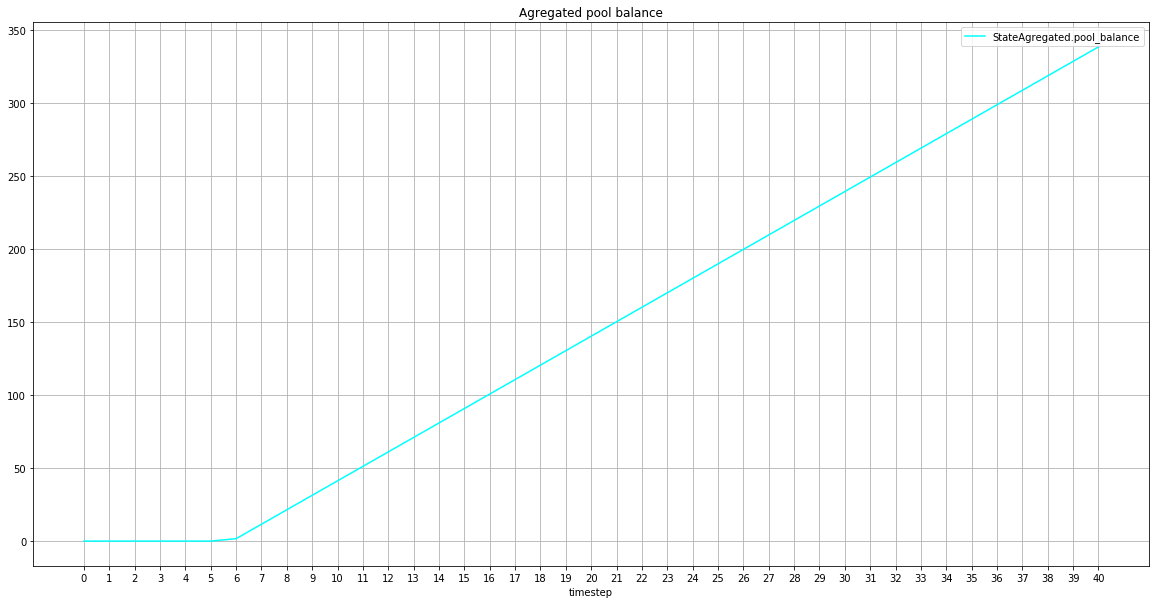

In [21]:
df = pd.DataFrame(raw_result)

mean_df,median_df,std_df,min_df = c2F.aggregate_runs(df,'timestep')

mean_df.plot('timestep', [StateAgregated.pool_balance], grid=True, 
        xticks=list(mean_df['timestep'].drop_duplicates()),
        title='Agregated pool balance',
        colormap=cm.get_cmap('cool'),
        figsize=(20,10));

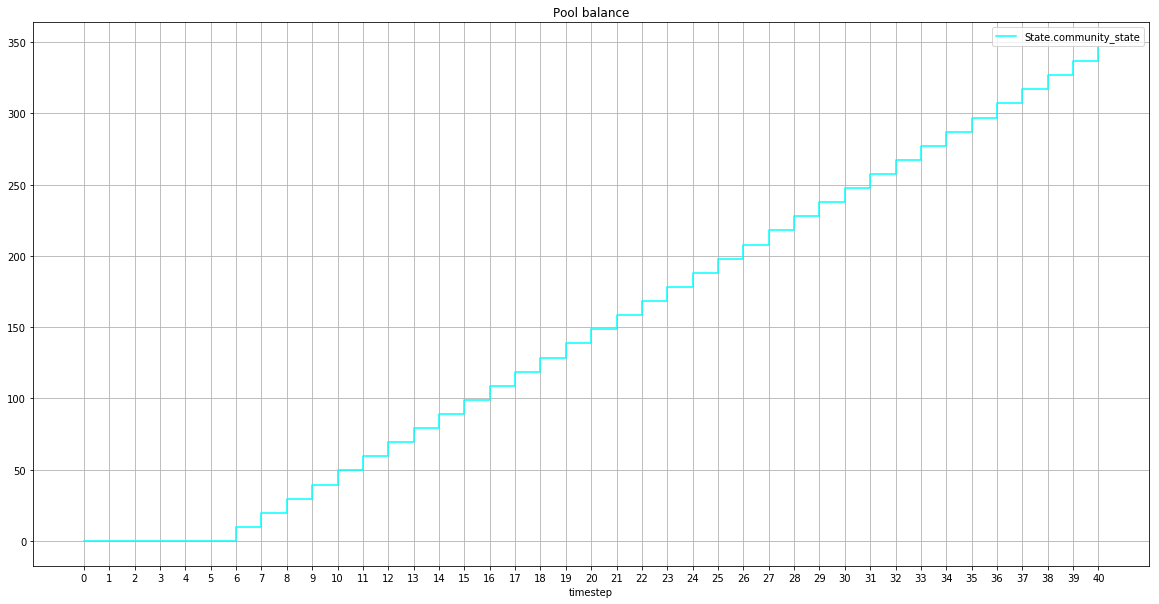

In [19]:
df = pd.DataFrame(raw_result)

df[State.community_state] = df[State.community_state].apply(lambda x: x.pool_balance)

df.plot('timestep', [State.community_state], grid=True, 
        xticks=list(df['timestep'].drop_duplicates()),
        title='Pool balance',
        colormap=cm.get_cmap('cool'),
        figsize=(20,10));

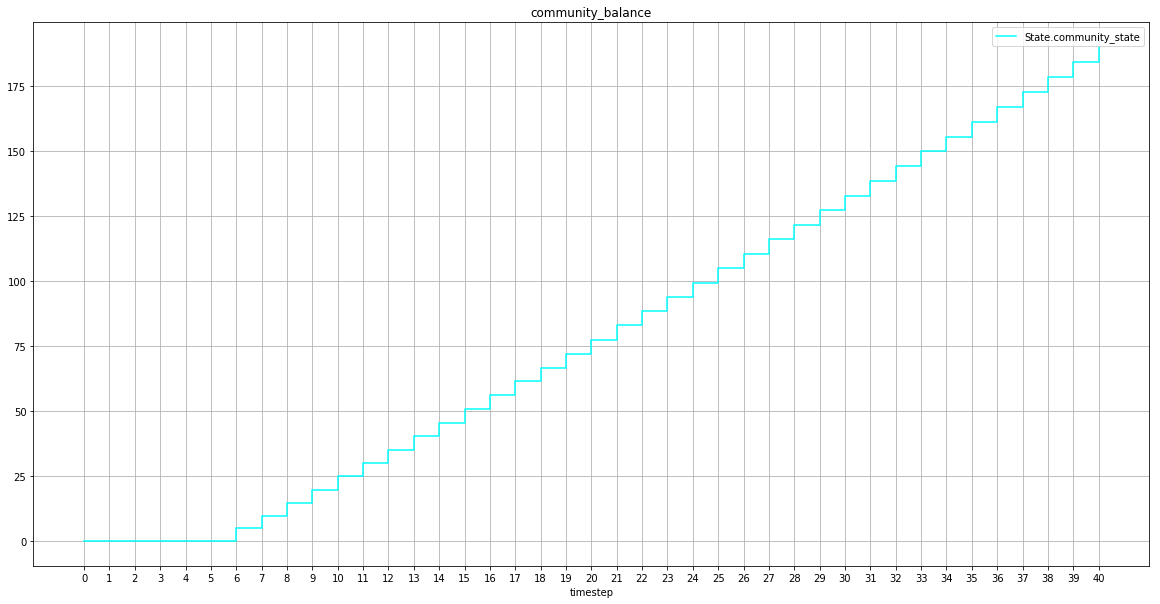

In [20]:
df = pd.DataFrame(raw_result)

df[State.community_state] = df[State.community_state].apply(lambda x: x.community_balance)

df.plot('timestep', [State.community_state], grid=True, 
        xticks=list(df['timestep'].drop_duplicates()),
        title='community_balance',
        colormap=cm.get_cmap('cool'),
        figsize=(20,10));

In [ ]:
df = pd.DataFrame(raw_result)
df[State.community_state] = df[State.community_state].apply(lambda x: x.pool_balance)

rolling_mean, upper_band, lower_band = bollinger_bands(df[State.community_state], 10, 2)

df['rolling_mean'] = rolling_mean
df['upper_band'] = upper_band
df['lower_band'] = lower_band
# # , 'rolling_mean', 'upper_band', 'lower_band'

df.plot('timestep', ['rolling_mean', 'upper_band', 'lower_band'], grid=True, 
        xticks=list(df['timestep'].drop_duplicates()), 
        title='Pool balance',
        colormap=cm.get_cmap('cool'),
        figsize=(20,10));

In [ ]:
df = pd.DataFrame(raw_result)
df['m0'] = df[State.community_state].apply(lambda x: x.members[0].user_supply)
df['m1'] = df[State.community_state].apply(lambda x: x.members[1].user_supply)
df['m2'] = df[State.community_state].apply(lambda x: x.members[2].user_supply)
df['m3'] = df[State.community_state].apply(lambda x: x.members[3].user_supply)

df.plot('timestep', ['m0', 'm1', 'm2', 'm3'], grid=True, 
        xticks=list(df['timestep'].drop_duplicates()), 
        title='User supply',
        colormap=cm.get_cmap('cool'),
        figsize=(20,10));

In [ ]:
df = pd.DataFrame(raw_result)
df['m0'] = df[State.community_state].apply(lambda x: x.members[0].user_balance)
df['m1'] = df[State.community_state].apply(lambda x: x.members[1].user_balance)
df['m2'] = df[State.community_state].apply(lambda x: x.members[2].user_balance)
df['m3'] = df[State.community_state].apply(lambda x: x.members[3].user_balance)

df.plot('timestep', ['m0', 'm1', 'm2', 'm3'], grid=True, 
        xticks=list(df['timestep'].drop_duplicates()), 
        title='User balance',
        colormap=cm.get_cmap('cool'),
        figsize=(20,10));

In [ ]:
from IPython.display import display
tmp_rows = pd.options.display.max_rows
pd.options.display.max_rows = 10
display(df.set_index(['run', 'timestep', 'substep']))
pd.options.display.max_rows = tmp_rows

In [ ]:
df.plot('timestep', [StateExogenous.tx_volume], grid=True, 
        xticks=list(df['timestep'].drop_duplicates()), 
        colormap = 'RdYlGn');
# yticks=list(range(1 + df[StateExogenous.tx_volume].max()))

In [ ]:
df.plot('timestep', [StateExogenous.product_cost], grid=True, 
        xticks=list(df['timestep'].drop_duplicates()), 
        colormap = 'RdYlGn');

In [ ]:
df.plot('timestep', [StateExogenous.user_base], grid=True, 
        xticks=list(df['timestep'].drop_duplicates()), 
        colormap = 'RdYlGn');

Here's what's happening with the y-shift. The collateral curve (curve integral), which is quadratic, gets shifted so that we're using the more linear part of the curve. This means the initial user is given an almost equivalent collateral buy-in to token reward ratio as future users. I think that's what we're seeing, without the y-shift the collateral to token ration is higher for the first user. See these two plots:
https://www.wolframalpha.com/input/?i=integral+of+y+%3D+x (edited) 
https://www.wolframalpha.com/input/?i=integral+of+y+%3D+x+%2B+0.5 (edited) 
So what we should be doing is designing for the collateral curve, rather than the bonding curve.

In [ ]:
%%latex
$$ f(s) = ms + b $$
$$ \int_s f(s) = \frac{1}{2}ms^2 + bs $$

$$ \int_p f^{-1}(p) = \sqrt{\frac{2*p}{m}} $$
$$ \int_p f^{-1}(p) = \frac{-b + \sqrt{b^2 + 2*m*p}}{m} $$

In [ ]:
# x-axis: bonding curve supply
# y-axis: buy-in collateral value
# z-axis: supply buy-in point

print("Creating mesh grid")

s = np.linspace(0, 10000, 100)
p = np.linspace(0, 10000, 100)

X, Y = np.meshgrid(s, p)

print("Calculating valuations")

# gradient = 1/17_500
# b = 0.5

gradient = 1/2000
b = 0

buy_in = 1 # dai

def valuation(current_supply, buy_in_supply):
    token_reward = collateral_to_token_selling(buy_in, buy_in_supply, gradient)
    pool_balance = curve_integral(current_supply, gradient)
    valuation = reward_for_burn(token_reward, current_supply, pool_balance, gradient)
    return max(0, (valuation - buy_in)/buy_in)

np_func = np.frompyfunc(valuation, 2, 1)

Z = np.nan_to_num(np_func(X, Y))

print("Creating surface")

surface = go.Surface(x=X, y=Y, z=Z)
data = [surface]

layout = go.Layout(
    title='Valuation Plot',
    scene=dict(
        xaxis=dict(
            title='Supply',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            title='Buy-in supply',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            title='ROI %',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)

print("Plotting figure")

# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='valuation_plot')

plt.contourf(X,Y,Z)
plt.colorbar()
plt.title('Value (ROI) distribution heatmap')
plt.xlabel('Supply')
plt.ylabel('Buy-in supply')
plt.show()

In [ ]:
print("Calculating valuations")

gradient = 1/17_500
b = 0.5

# gradient = 1/2000
# b = 0

buy_in = 1 # dai

def valuation(current_supply, buy_in_supply):
    token_reward = collateral_to_token_selling(buy_in, buy_in_supply, gradient)
    pool_balance = curve_integral(current_supply, gradient)
    valuation = reward_for_burn(token_reward, current_supply, pool_balance, gradient)
    return max(0, (valuation - buy_in)/buy_in)

np_func = np.frompyfunc(valuation, 2, 1)

Z = np.nan_to_num(np_func(X, Y))

print("Creating surface")

surface = go.Surface(x=X, y=Y, z=Z)
data = [surface]

layout = go.Layout(
    title='Valuation Plot',
    scene=dict(
        xaxis=dict(
            title='Supply',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            title='Buy-in supply',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            title='ROI %',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)

print("Plotting figure")

# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='valuation_plot')

plt.contourf(X,Y,Z)
plt.colorbar()
plt.title('Value (ROI) distribution heatmap')
plt.xlabel('Supply')
plt.ylabel('Buy-in supply')
plt.savefig('Value (ROI) distribution heatmap.png')
plt.show()

In [ ]:
# Initially concerned about behaviour of bonding curve collateral pool growth, but when you consider users, 
# who concern themselves with token value and ROI, a different story emerges.

# Consider: Collateral pool vs. user balance

# Independant variables
# 1 Dof vs. 2 Dof
# Current supply vs. current supply & buy-in point

# Better represented as a 3D plane
# Results in system being dependant on user growth rather than just supply

# Optimization problem:
## Cost function: minimize the gradient (level the "playing field")

In [130]:
import math
import numpy as np

default_input = [100.0*1e18, 200.0*1e18]

def integral(_x=default_input):
    DECIMALS = 18

    x = np.multiply(_x, math.pow(10.0, DECIMALS - 18))
    a = 25.0*math.pow(10.0, DECIMALS - 6)
    b = 5.0*math.pow(10.0, DECIMALS - 1)

    return np.multiply(a*x/math.pow(10, DECIMALS) + b, x)/math.pow(10, DECIMALS)

integral()

array([5.025e+19, 1.010e+20])

In [131]:
default_input = integral()

def inverse_integral(_x=default_input):
    # Use 36 decimal places for improved square root precision
    DECIMALS = 36

    x = np.multiply(_x, math.pow(10, 18))
    prefix = 200*math.pow(10, DECIMALS)
    a = prefix*np.sqrt(x + 2500*math.pow(10, DECIMALS))/np.sqrt(math.pow(10, DECIMALS));

    result = (-10_000*math.pow(10, DECIMALS) + a)/math.pow(10, 18);
    return result;

inverse_integral()

array([1.e+20, 2.e+20])

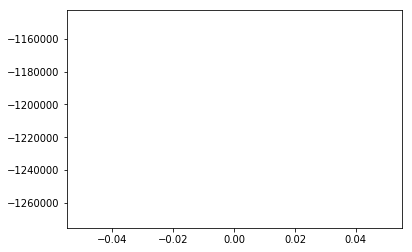

In [154]:
x = np.arange(0.0, 1_000_000.0, 1_000_000_000, dtype=np.int64)
x = np.multiply(x, math.pow(10, 18))
# print(x)
y1 = integral(x)
y2 = inverse_integral(y1)

z = np.subtract(y2, x)

import matplotlib.pyplot as plt
plt.plot(x, z, 'r')